## BIOS 470/570 Lecture 13

## Last time we covered:
* ### Clustering single cell data
* ### controlling for unwanted sources of variability
  - #### regress_out function
* ### combining single cell datasets

## Today we will cover:
* ### Modeling the data and eliminating unwanted variation with scvi
* ### pseudotime analysis

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scvi


## Using scvi to eliminate unwanted variation:

### First read the data 

In [2]:
adata = sc.read_h5ad('data/multiBatch.h5ad')

### scVI requires the raw count data so we will store this in a separate layer to use in making the model.

In [ ]:
adata.layers["counts"] = adata.X.copy() #make a layer for the raw counts

### Standard preprocessing and visualization of the data. This shows the problems with had last time that we need to address:

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata #set the raw data to the filtered, logarithimized data.

sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata = adata[:,adata.var.highly_variable]

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

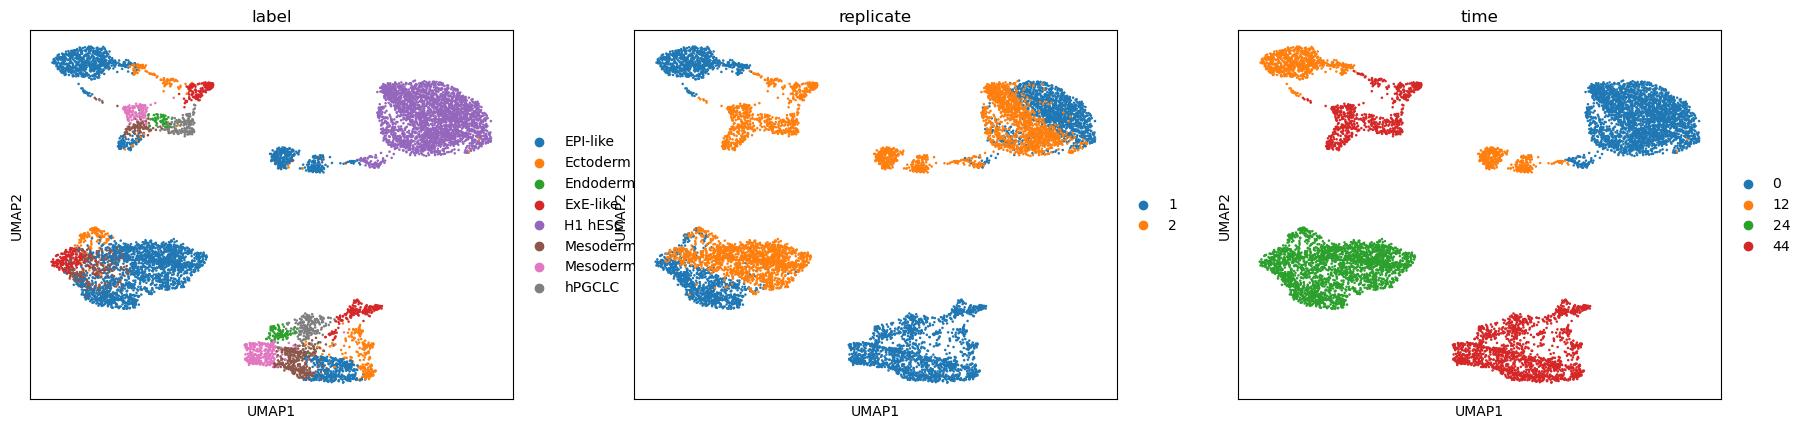

In [21]:
sc.pl.umap(adata, color = ["label","replicate","time"])

### This modifies the anndata object sot that it is setup for running scvi

In [52]:
scvi.model.SCVI.setup_anndata(adata,layer="counts",batch_key="replicate")

### This creates the model. The model creates a "latent space" where the high dimensional gene expression is model. You can specify the number of components to keep in this space. Here we use 30. This is dimensionality reduction to create the model but not for visualization. 

In [53]:
vae = scvi.model.SCVI(adata_all, n_layers=2, n_latent=30)

### This does the actual computation to train the model. There is a progress bar below. This took about 10 minutes to run here:

In [54]:
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [09:16<00:00,  1.39s/it, loss=1.4e+03, v_num=1]


### This stores the latent representation in the anndata object so that it can be used for other computations. You can also save the model in a file for future use with vae.save(). You can also get the predicted expression of individual genes in the model with vae.get_normalized_expression(adata) 

In [55]:
adata_all.obsm["X_scVI"] = vae.get_latent_representation()

### Now we will make a umap using the representation from the scVI latent space instead of the gene expression space or pca:


In [56]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata_all, use_rep="X_scVI")
sc.tl.umap(adata_all, min_dist=0.3)

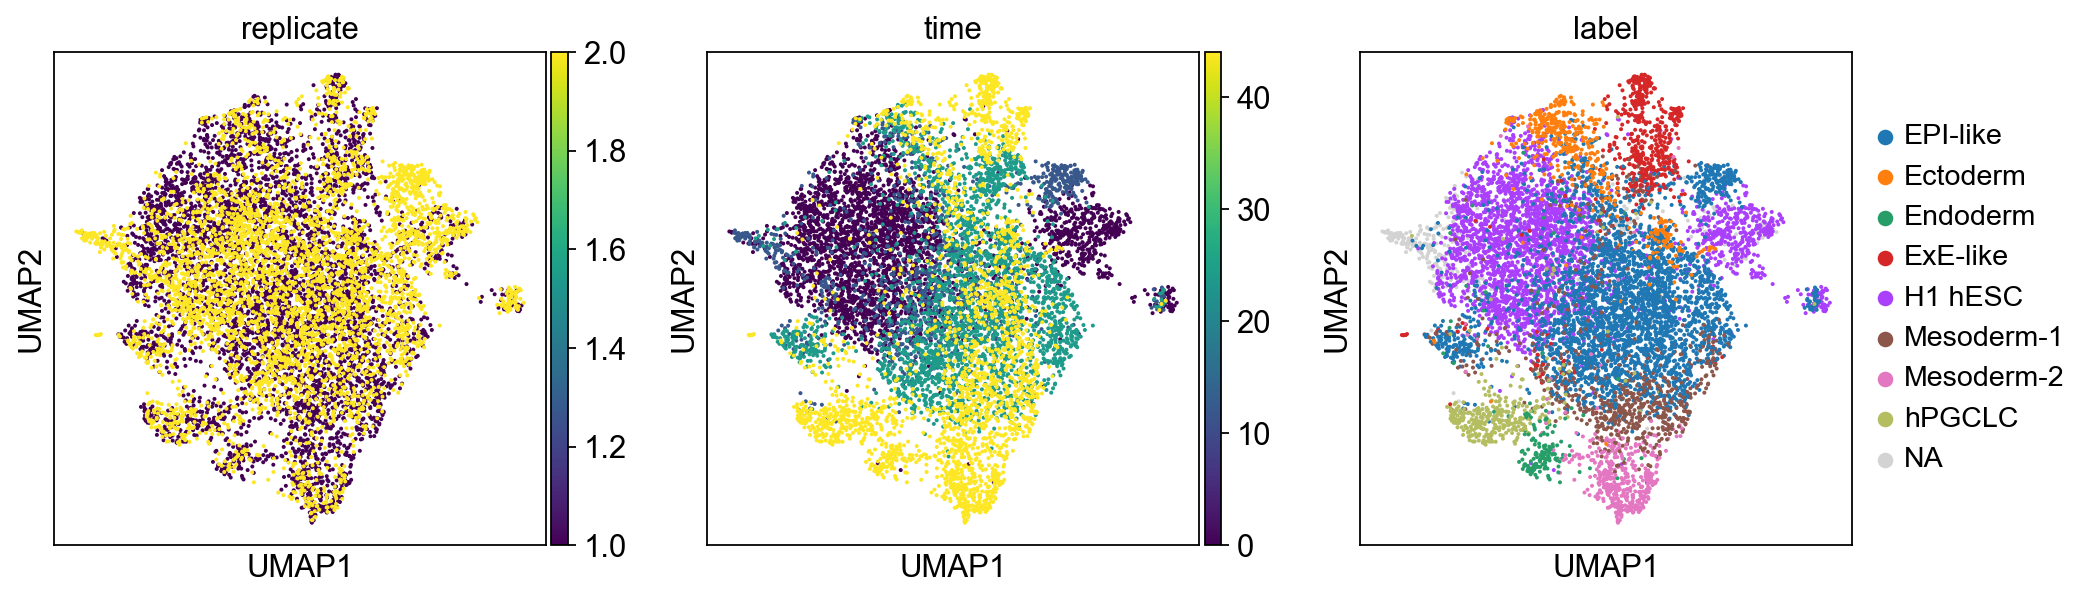

In [57]:
sc.pl.umap(adata_all,color = ['replicate','time','label'])

### This looks lot better than before. The replicates are pretty well mixed and there are reasonable relationships between the cell types.

## Examining trajectories with pseudotime:

### We will use an example dataset which is built into scanpy of hematopoesis. Here a progenitor splits into erythrocyte and myleloid lineages, which then splits into monocytes and neutrophils

In [3]:
adata = sc.datasets.paul15()

### scanpy has some standard preprocessing recipes built in for the filtering we have been doing. For ease, we will use one here:

In [4]:
sc.pp.recipe_zheng17(adata)

### PCA and neighbor algorithms. We can specify the number of neighbors to use and the number of principle components to use in computing them:

In [7]:
sc.tl.pca(adata,svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=4,n_pcs=20)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### This uses another method of dimensionality reduction which is especially suitable for inferring pseudotime and trajectories. You may need to install a package called fa2 with pip install fa2 for this to run. Do this not in your scvi directory (this broke scvi for me...)

In [16]:
sc.tl.draw_graph(adata)

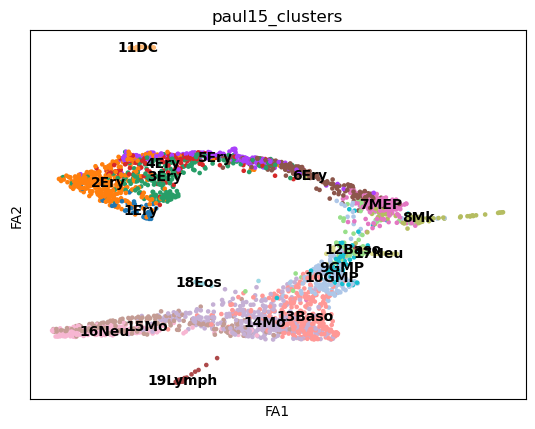

In [17]:
sc.pl.draw_graph(adata,color='paul15_clusters',legend_loc='on data')

### To use the pseudotime algorithm, we need to specify which cells are the progenitors. Here the cluster labelled "7MEP" are the myeloid-erythroid progenitors. The algorithm expects the indices of these cells to be stored in the 'iroot' entry in .uns:

In [18]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['paul15_clusters'] == '7MEP')[0]

### Run the pseudotime algorithm:

In [19]:
sc.tl.dpt(adata)

### Let's see the pseudotime mapped to each cell:

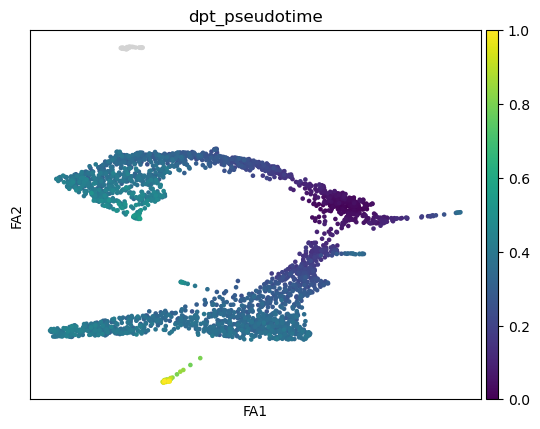

In [21]:
sc.pl.draw_graph(adata,color = 'dpt_pseudotime')